In [25]:
import pandas as pd
pd.options.display.max_rows = 999
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [26]:
start = datetime(2017, 9, 1)
end = datetime(2018, 9, 10)
stocks = ['UA', 'ADS', 'NKE']
UnderArmour = web.DataReader(stocks[2], 'robinhood', start, end)
Adidas = web.DataReader(stocks[1], 'robinhood', start, end)
Nike = web.DataReader(stocks[2], 'robinhood', start, end)

In [27]:
UnderArmour.tail()

close_price high_price  interpolated  low_price open_price  \
symbol begins_at                                                               
NKE    2018-10-15   74.990000  76.160000         False  74.970000  75.770000   
       2018-10-16   77.480000  77.650000         False  75.320000  75.600000   
       2018-10-17   76.480000  77.800000         False  75.940000  77.520000   
       2018-10-18   75.600000  77.410000         False  75.003100  77.400000   
       2018-10-19   74.210000  76.050000         False  74.140000  75.830000   

                  session   volume  
symbol begins_at                    
NKE    2018-10-15     reg  5789049  
       2018-10-16     reg  7744185  
       2018-10-17     reg  6816903  
       2018-10-18     reg  7622219  
       2018-10-19     reg  7301200

In [28]:
UnderArmour.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 252 entries, (NKE, 2017-10-20 00:00:00) to (NKE, 2018-10-19 00:00:00)
Data columns (total 7 columns):
close_price     252 non-null object
high_price      252 non-null object
interpolated    252 non-null bool
low_price       252 non-null object
open_price      252 non-null object
session         252 non-null object
volume          252 non-null int64
dtypes: bool(1), int64(1), object(5)
memory usage: 14.9+ KB


In [29]:
UnderArmour.reset_index(inplace= True)
UnderArmour.head()

,symbol,begins_at,close_price,high_price,interpolated,low_price,open_price,session,volume
0,NKE,2017-10-20,52.448800,52.883800,False,52.181900,52.181900,reg,13020916
1,NKE,2017-10-23,53.041900,53.328600,False,52.389500,52.448800,reg,12242580
2,NKE,2017-10-24,52.804700,53.378000,False,52.488400,53.279200,reg,14767595
3,NKE,2017-10-25,54.307200,55.261100,False,52.063300,52.814600,reg,24804028
4,NKE,2017-10-26,56.155600,56.590600,False,54.504900,54.623500,reg,22185144


In [30]:
UnderArmour.drop(['symbol','interpolated', 'session'], axis = 1, inplace = True)
UnderArmour.head()

,begins_at,close_price,high_price,low_price,open_price,volume
0,2017-10-20,52.448800,52.883800,52.181900,52.181900,13020916
1,2017-10-23,53.041900,53.328600,52.389500,52.448800,12242580
2,2017-10-24,52.804700,53.378000,52.488400,53.279200,14767595
3,2017-10-25,54.307200,55.261100,52.063300,52.814600,24804028
4,2017-10-26,56.155600,56.590600,54.504900,54.623500,22185144


In [31]:
UnderArmour.set_index('begins_at', inplace = True)
UnderArmour.head()

,close_price,high_price,low_price,open_price,volume
begins_at,,,,,
2017-10-20,52.448800,52.883800,52.181900,52.181900,13020916
2017-10-23,53.041900,53.328600,52.389500,52.448800,12242580
2017-10-24,52.804700,53.378000,52.488400,53.279200,14767595
2017-10-25,54.307200,55.261100,52.063300,52.814600,24804028
2017-10-26,56.155600,56.590600,54.504900,54.623500,22185144


In [32]:
for col in ['close_price', 'high_price', 'low_price', 'open_price']:
    UnderArmour[col] = UnderArmour[col].astype(float)
UnderArmour.dtypes

close_price    float64
high_price     float64
low_price      float64
open_price     float64
volume           int64
dtype: object

In [33]:
UnderArmour.head()

,close_price,high_price,low_price,open_price,volume
begins_at,,,,,
2017-10-20,52.4488,52.8838,52.1819,52.1819,13020916
2017-10-23,53.0419,53.3286,52.3895,52.4488,12242580
2017-10-24,52.8047,53.3780,52.4884,53.2792,14767595
2017-10-25,54.3072,55.2611,52.0633,52.8146,24804028
2017-10-26,56.1556,56.5906,54.5049,54.6235,22185144


In [34]:
#UnderArmour.sort_index(axis = 0, ascending= False)#,  inplace = True)

In [35]:
# Calculating the MACD
UnderArmour['ewm_12'] = UnderArmour['close_price'].ewm(span=12).mean()
UnderArmour['ewm_26'] = UnderArmour['close_price'].ewm(span=26).mean()
UnderArmour['macd'] = UnderArmour['ewm_12'] - UnderArmour['ewm_26']
UnderArmour['signal'] = UnderArmour['macd'].ewm(span=9).mean()
UnderArmour['macd_hist'] = UnderArmour['macd'] - UnderArmour['signal']

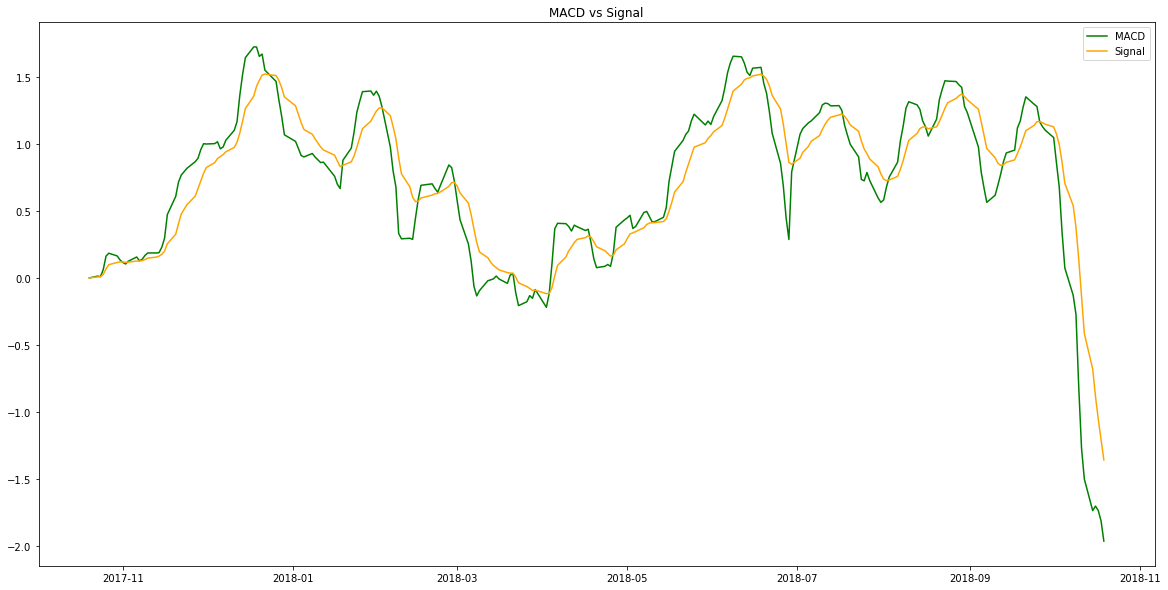

In [36]:
plt.figure(figsize=(20,10))
plt.plot(UnderArmour['macd'], color = 'green', label = 'MACD')
plt.plot(UnderArmour['signal'], color = 'orange', label = 'Signal')
#plt.plot(UnderArmour['macd_hist'], label = 'MACD_hist')
plt.legend()
plt.title('MACD vs Signal');

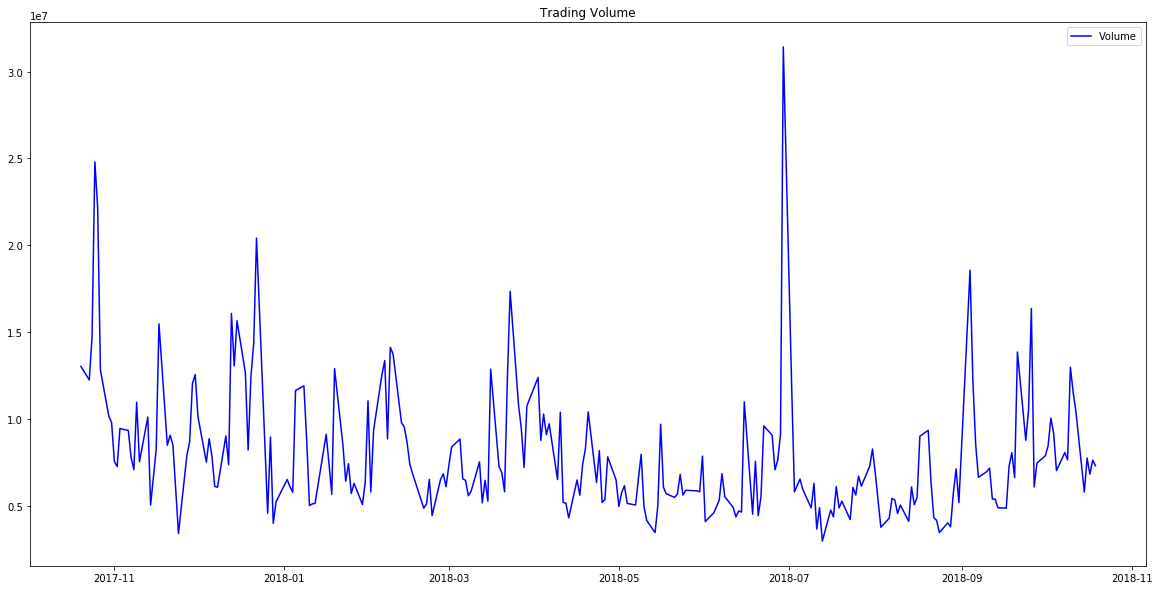

In [37]:
plt.figure(figsize=(20,10))
plt.plot(UnderArmour['volume'], color = 'b', label = 'Volume')
plt.title('Trading Volume')
plt.legend()
plt.show()

In [38]:
# Calculating the Directional Movements
UnderArmour['prior_high'] = UnderArmour['high_price'].shift()
UnderArmour['prior_low'] = UnderArmour['low_price'].shift()
UnderArmour['prior_close'] = UnderArmour['close_price'].shift() 
UnderArmour['prior_range'] = UnderArmour['prior_high'] - UnderArmour['prior_low']
UnderArmour['current_range'] = UnderArmour['high_price'] - UnderArmour['low_price']
# Momentum and Rate of Change
UnderArmour['close_price_7'] = UnderArmour['close_price'].shift(7)
UnderArmour['momentum'] = UnderArmour['close_price'] - UnderArmour['close_price_7']
UnderArmour['rate_of_change'] = UnderArmour['close_price']/UnderArmour['close_price_7']
# Smoothed Rate of Change
UnderArmour['ema_13'] = UnderArmour['close_price'].ewm(span=13).mean()
UnderArmour['close_price_21'] = UnderArmour['close_price'].shift(21)
UnderArmour['rate_of_change_21'] = UnderArmour['close_price']/UnderArmour['close_price_21']
UnderArmour['s_rate_of_change'] = UnderArmour['ema_13']/UnderArmour['rate_of_change_21']
# Williams % R
UnderArmour['prior_high_2'] = UnderArmour['high_price'].shift(2)
UnderArmour['prior_high_3'] = UnderArmour['high_price'].shift(3)
UnderArmour['prior_high_4'] = UnderArmour['high_price'].shift(4)
UnderArmour['prior_high_5'] = UnderArmour['high_price'].shift(5)
UnderArmour['prior_high_6'] = UnderArmour['high_price'].shift(6)
UnderArmour['highest_high'] = UnderArmour[['high_price', 'prior_high', 'prior_high_2', 'prior_high_3', 'prior_high_4', 'prior_high_5','prior_high_6']].max(axis = 1)
UnderArmour['prior_low_2'] = UnderArmour['low_price'].shift(2)
UnderArmour['prior_low_3'] = UnderArmour['low_price'].shift(3)
UnderArmour['prior_low_4'] = UnderArmour['low_price'].shift(4)
UnderArmour['prior_low_5'] = UnderArmour['low_price'].shift(5)
UnderArmour['prior_low_6'] = UnderArmour['low_price'].shift(6)
UnderArmour['lowest_low'] = UnderArmour[['low_price', 'prior_low', 'prior_low_2', 'prior_low_3', 'prior_low_4', 'prior_low_5','prior_low_6']].min(axis = 1)
UnderArmour['wm%R'] = 100*((UnderArmour['highest_high'] - UnderArmour['close_price'])/(UnderArmour['highest_high'] - UnderArmour['lowest_low']))
# Accumulation/Distribution
UnderArmour['a/d'] = ((UnderArmour['close_price'] - UnderArmour['open_price'])/(UnderArmour['high_price'] - UnderArmour['low_price'])*UnderArmour['volume'])
# Elder-Ray
UnderArmour['bull_power'] = UnderArmour['high_price'] - UnderArmour['ema_13']
UnderArmour['bear_power'] = UnderArmour['low_price'] - UnderArmour['ema_13']
# Force Index
UnderArmour['force_index'] = UnderArmour['volume'] * (UnderArmour['close_price'] - UnderArmour['prior_close'])
UnderArmour['force_index_2'] = UnderArmour['force_index'].ewm(span=2).mean()
UnderArmour['force_index_13'] = UnderArmour['force_index'].ewm(span=13).mean()
# Bollinger Bands
UnderArmour['bollinger_dev'] = (UnderArmour['close_price'] - UnderArmour['close_price_21'])*2
UnderArmour['bollinger_upp'] = UnderArmour['close_price_21'] + UnderArmour['bollinger_dev']
UnderArmour['bollinger_low'] = UnderArmour['close_price_21'] - UnderArmour['bollinger_dev']
UnderArmour.head()

,close_price,high_price,low_price,open_price,volume,ewm_12,ewm_26,macd,signal,macd_hist,...,wm%R,a/d,bull_power,bear_power,force_index,force_index_2,force_index_13,bollinger_dev,bollinger_upp,bollinger_low
begins_at,,,,,,,,,,,,,,,,,,,,,
2017-10-20,52.4488,52.8838,52.1819,52.1819,13020916,52.448800,52.448800,0.000000,0.000000,0.000000,...,61.974640,4.951250e+06,0.435000,-0.266900,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-23,53.0419,53.3286,52.3895,52.4488,12242580,52.770062,52.756756,0.013307,0.007393,0.005914,...,25.002180,7.731950e+06,0.560438,-0.378662,7.261074e+06,7.261074e+06,7.261074e+06,NaN,NaN,NaN
2017-10-24,52.8047,53.3780,52.4884,53.2792,14767595,52.783582,52.773982,0.009600,0.008297,0.001303,...,47.930775,-7.876825e+06,0.595741,-0.293859,-3.502874e+06,-8.118866e+05,1.465102e+06,NaN,NaN,NaN
2017-10-25,54.3072,55.2611,52.0633,52.8146,24804028,53.264528,53.202603,0.061926,0.026464,0.035462,...,29.829883,1.157749e+07,2.005488,-1.192312,3.726805e+07,2.555115e+07,1.527884e+07,NaN,NaN,NaN
2017-10-26,56.1556,56.5906,54.5049,54.6235,22185144,54.050022,53.887415,0.162607,0.066964,0.095644,...,9.608376,1.629662e+07,2.563991,0.478291,4.100702e+07,3.598386e+07,2.326505e+07,NaN,NaN,NaN


In [39]:
indicators = UnderArmour[['macd','wm%R','a/d','bear_power','bull_power']] 

In [127]:
# # Calculate the True Range
# UnderArmour['TR_A'] = UnderArmour['high_price'] - UnderArmour['low_price']
# UnderArmour['TR_B'] = UnderArmour['high_price'] - UnderArmour['prior_close']
# UnderArmour['TR_C'] = UnderArmour['low_price'] - UnderArmour['prior_close']
# UnderArmour['TR'] = UnderArmour[['TR_A', 'TR_B', 'TR_C']].max(axis = 1)
# max(UnderArmour['TR_A'][0], UnderArmour['TR_B'][0], UnderArmour['TR_C'][0])
# print(UnderArmour['TR_A'][3], UnderArmour['TR_B'][3], UnderArmour['TR_C'][3])
# max(UnderArmour['TR_A'][3], UnderArmour['TR_B'][1], UnderArmour['TR_C'][1])

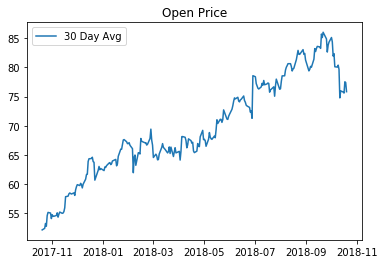

In [251]:
plt.plot(UnderArmour['open_price'], label = '30 Day Avg')
plt.title('Open Price')
plt.legend();

In [129]:
print('1 Day Lag AutoCorr', UnderArmour['open_price'].autocorr(lag=1))
print('2 Day Lag AutoCorr', UnderArmour['open_price'].autocorr(lag=2))
print('3 Day Lag AutoCorr', UnderArmour['open_price'].autocorr(lag=3))
print('4 Day Lag AutoCorr', UnderArmour['open_price'].autocorr(lag=4))
print('5 Day Lag AutoCorr', UnderArmour['open_price'].autocorr(lag=5))
print('6 Day Lag AutoCorr', UnderArmour['open_price'].autocorr(lag=6))
print('7 Day Lag AutoCorr', UnderArmour['open_price'].autocorr(lag=7))
print('8 Day Lag AutoCorr', UnderArmour['open_price'].autocorr(lag=8))
print('9 Day Lag AutoCorr', UnderArmour['open_price'].autocorr(lag=9))
print('10 Day Lag AutoCorr', UnderArmour['open_price'].autocorr(lag=10))
print('11 Day Lag AutoCorr', UnderArmour['open_price'].autocorr(lag=11))
print('12 Day Lag AutoCorr', UnderArmour['open_price'].autocorr(lag=12))
print('13 Day Lag AutoCorr', UnderArmour['open_price'].autocorr(lag=13))
print('14 Day Lag AutoCorr', UnderArmour['open_price'].autocorr(lag=14))
print('15 Day Lag AutoCorr', UnderArmour['open_price'].autocorr(lag=15))
print('16 Day Lag AutoCorr', UnderArmour['open_price'].autocorr(lag=16))
print('17 Day Lag AutoCorr', UnderArmour['open_price'].autocorr(lag=17))
print('18 Day Lag AutoCorr', UnderArmour['open_price'].autocorr(lag=18))
print('19 Day Lag AutoCorr', UnderArmour['open_price'].autocorr(lag=19))
print('20 Day Lag AutoCorr', UnderArmour['open_price'].autocorr(lag=20))
print('25 Day Lag AutoCorr', UnderArmour['open_price'].autocorr(lag=25))
print('30 Day Lag AutoCorr', UnderArmour['open_price'].autocorr(lag=30))

1 Day Lag AutoCorr 0.9915151338428394
2 Day Lag AutoCorr 0.9848133361349389
3 Day Lag AutoCorr 0.9795538016326342
4 Day Lag AutoCorr 0.9737319851259201
5 Day Lag AutoCorr 0.9693218920247237
6 Day Lag AutoCorr 0.9658509899257314
7 Day Lag AutoCorr 0.9605567485537867
8 Day Lag AutoCorr 0.9552940739417523
9 Day Lag AutoCorr 0.9513802807344973
10 Day Lag AutoCorr 0.9482838540420141
11 Day Lag AutoCorr 0.9451470086639305
12 Day Lag AutoCorr 0.9423284984516326
13 Day Lag AutoCorr 0.9398776471193558
14 Day Lag AutoCorr 0.9389525620113264
15 Day Lag AutoCorr 0.9383902775298414
16 Day Lag AutoCorr 0.938013656343422
17 Day Lag AutoCorr 0.9365721286577238
18 Day Lag AutoCorr 0.9325583119051967
19 Day Lag AutoCorr 0.9292949980249285
20 Day Lag AutoCorr 0.9259278169732159
25 Day Lag AutoCorr 0.9206190298272845
30 Day Lag AutoCorr 0.9061619433196865


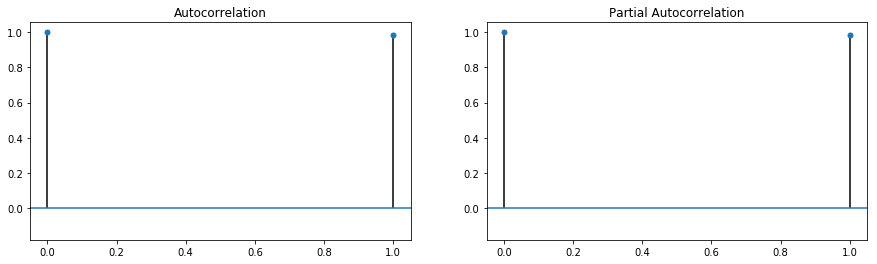

In [130]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(UnderArmour['open_price'], lags = 1, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(UnderArmour['open_price'], lags = 1, ax=axes[1])
plt.show()

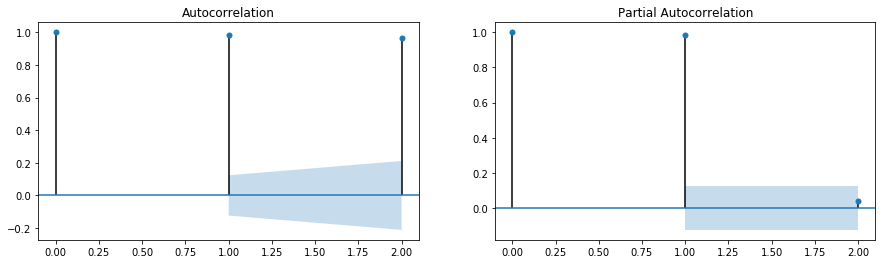

In [131]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(UnderArmour['open_price'], lags = 2, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(UnderArmour['open_price'], lags = 2, ax=axes[1])
plt.show()

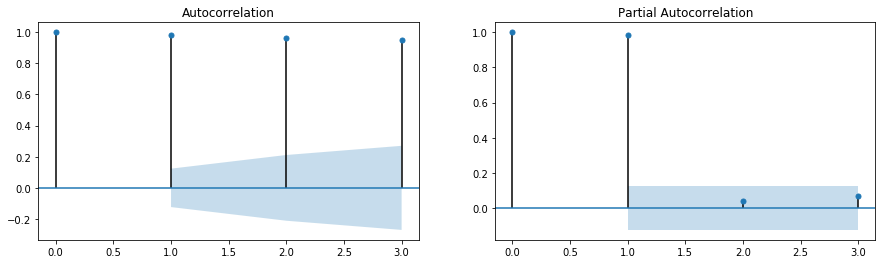

In [132]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(UnderArmour['open_price'], lags = 3, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(UnderArmour['open_price'], lags = 3, ax=axes[1])
plt.show()

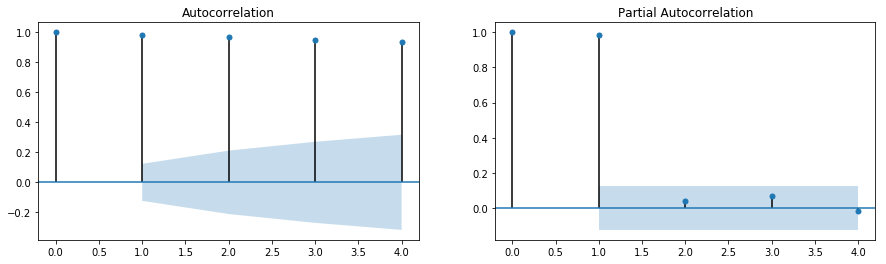

In [133]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(UnderArmour['open_price'], lags = 4, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(UnderArmour['open_price'], lags = 4, ax=axes[1])
plt.show()

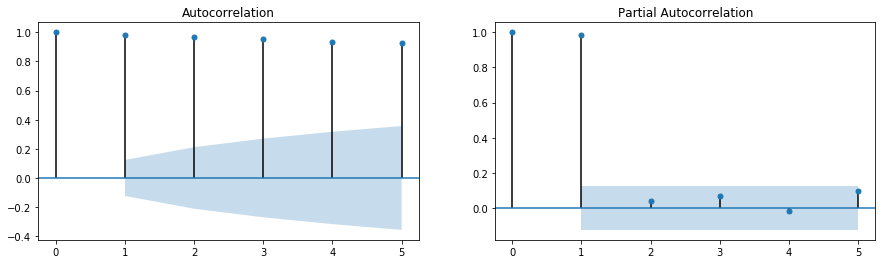

In [134]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(UnderArmour['open_price'], lags = 5, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(UnderArmour['open_price'], lags = 5, ax=axes[1])
plt.show()

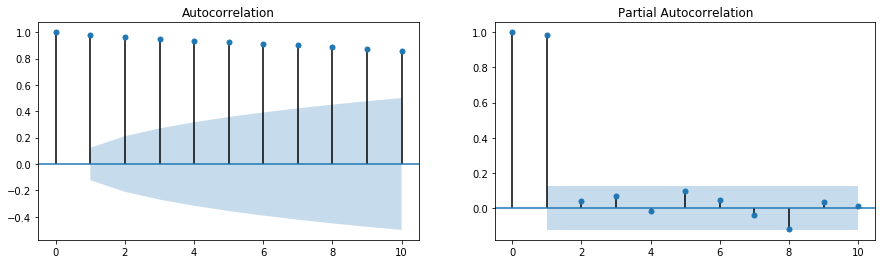

In [135]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(UnderArmour['open_price'], lags = 10, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(UnderArmour['open_price'], lags = 10, ax=axes[1])
plt.show()

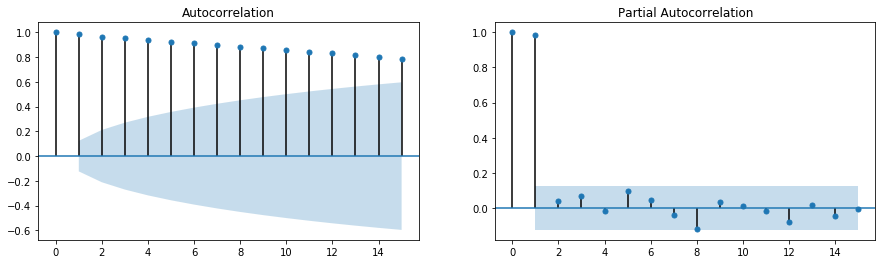

In [136]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(UnderArmour['open_price'], lags = 15, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(UnderArmour['open_price'], lags = 15, ax=axes[1])
plt.show()

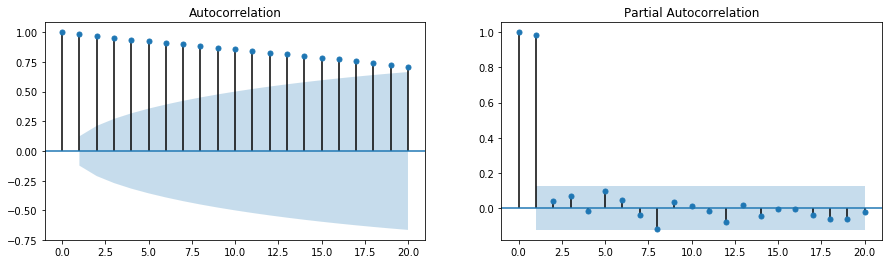

In [137]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(UnderArmour['open_price'], lags = 20, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(UnderArmour['open_price'], lags = 20, ax=axes[1])
plt.show()

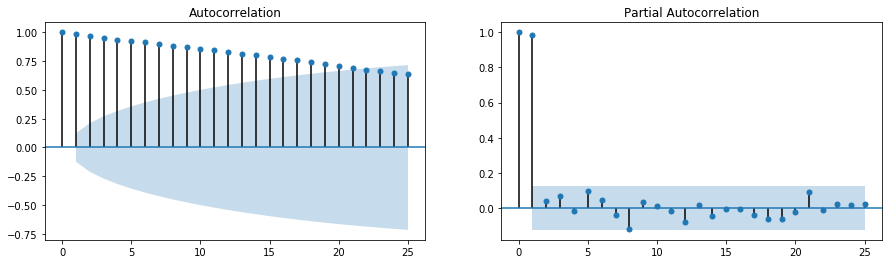

In [138]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(UnderArmour['open_price'], lags = 25, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(UnderArmour['open_price'], lags = 25, ax=axes[1])
plt.show()

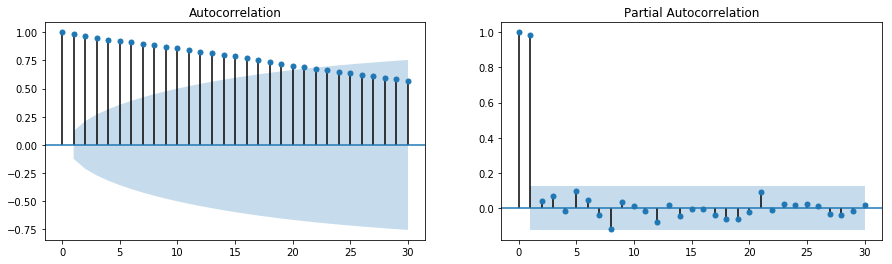

In [255]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(UnderArmour['open_price'], lags = 30, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(UnderArmour['open_price'], lags = 30, ax=axes[1])
plt.show()

<Figure size 432x288 with 0 Axes>

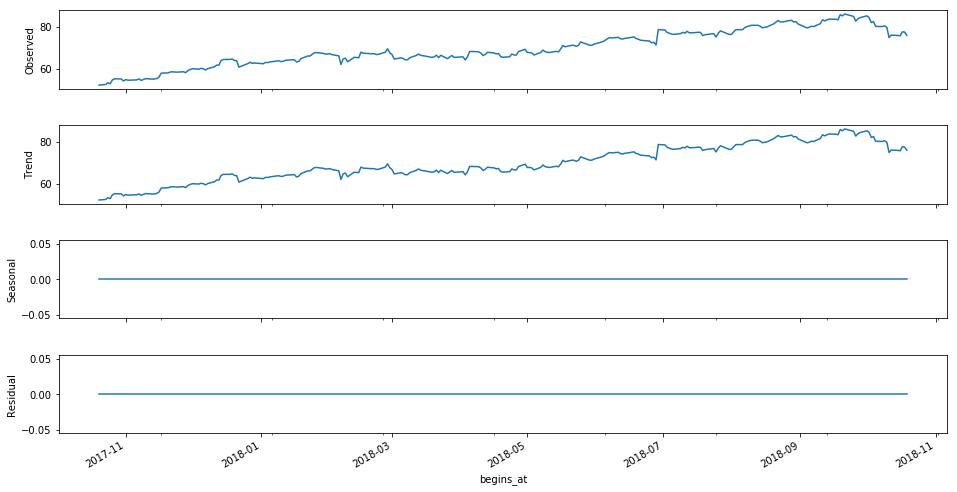

In [140]:
decomposition = seasonal_decompose(UnderArmour['open_price'], freq=1)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [114]:
stationarity_test = UnderArmour['open_price']
result = adfuller(stationarity_test)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.023078
p-value: 0.276547


In [141]:
UnderArmour['first_difference'] = UnderArmour['open_price'].diff()

In [142]:
X = UnderArmour['first_difference'].dropna()
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -12.844360
p-value: 0.000000


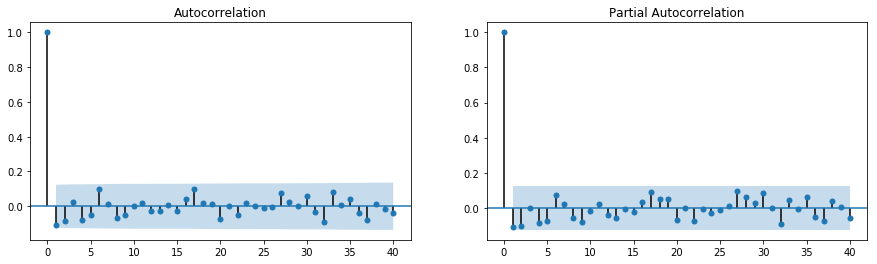

In [153]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(X, lags = 40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(X, lags = 40, ax=axes[1])
plt.show()

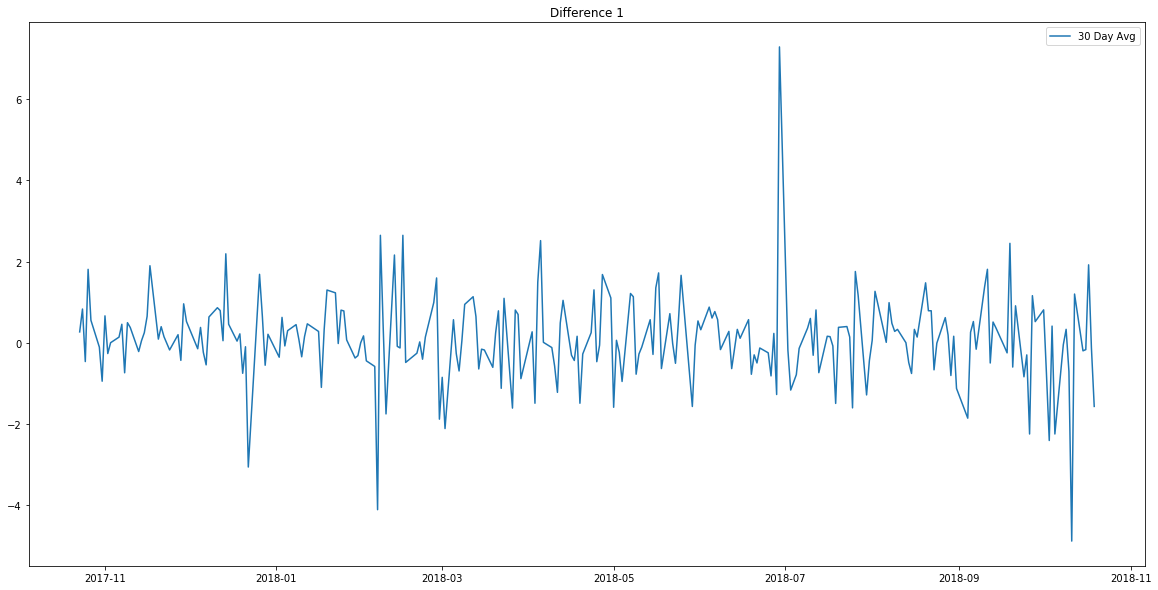

In [249]:
plt.figure(figsize=(20,10))
plt.plot(X, label = '30 Day Avg')
plt.title(label = 'Difference 1')
plt.legend();

In [40]:
test = UnderArmour['open_price'].count()
model = sarimax.SARIMAX(UnderArmour['open_price'], exog= indicators, order=(1, 1, 0),seasonal_order=(0,0,0,0) )
results = model.fit()


y_hat = results.predict()
mean_squared_error(UnderArmour['open_price'], y_hat)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


11.11600643985462

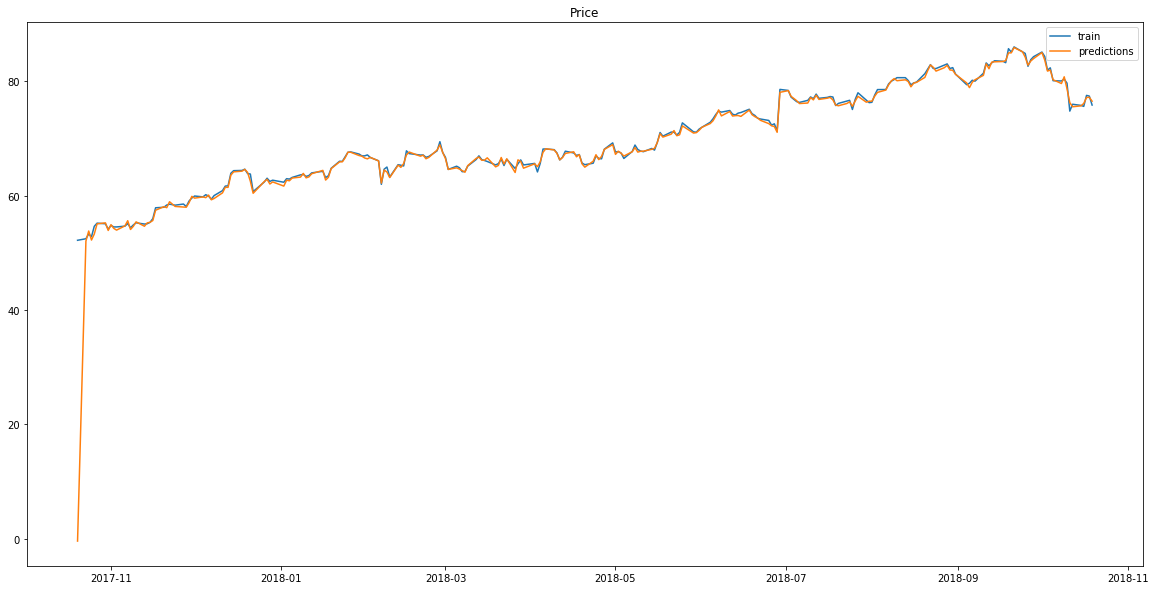

In [42]:
plt.figure(figsize=(20,10))
plt.plot(UnderArmour['open_price'], label='train')
plt.plot(y_hat, label='predictions')
plt.title('Price')
plt.legend();

In [ ]:
## Prediction

In [44]:
y_hat_future = results.predict()

In [45]:
y_hat_future

begins_at
2017-10-20    -0.427900
2017-10-23    52.038412
2017-10-24    53.800457
2017-10-25    52.222006
2017-10-26    53.274886
2017-10-27    55.047983
2017-10-30    55.228972
2017-10-31    53.900983
2017-11-01    54.902407
2017-11-02    54.260888
2017-11-03    53.957479
2017-11-06    54.700183
2017-11-07    55.600737
2017-11-08    54.068249
2017-11-09    54.617160
2017-11-10    55.402182
2017-11-13    54.638072
2017-11-14    55.223995
2017-11-15    55.323623
2017-11-16    55.634394
2017-11-17    57.438443
2017-11-20    58.060846
2017-11-21    57.886475
2017-11-22    58.920107
2017-11-24    58.102255
2017-11-27    57.995677
2017-11-28    57.960859
2017-11-29    58.748193
2017-11-30    59.862764
2017-12-01    59.552034
2017-12-04    59.766018
2017-12-05    59.634176
2017-12-06    60.086210
2017-12-07    59.261438
2017-12-08    59.491456
2017-12-11    60.471148
2017-12-12    61.445672
2017-12-13    61.437709
2017-12-14    63.571835
2017-12-15    64.149229
2017-12-18    64.269441
2017-1